In [8]:
import numpy as np
import pandas as pd
import pickle
import os
import pickle
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization, iterations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
import matplotlib.colors as mcolors
import textwrap

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging 
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

# Load original_bulk_data from the file
bulk_data_input_file = '../../../old_trials/hypermatrix/projects/single_cell_files/nan_removed_bulk_data.pkl'
with open(bulk_data_input_file, 'rb') as f:
    bulk_data = pickle.load(f)
print(f"bulk_data loaded from {bulk_data_input_file}")

# Load original_bulk_data from the file
original_bulk_data_input_file = '../../../old_trials/hypermatrix/projects/single_cell_files/original_bulk_data.pkl'
with open(original_bulk_data_input_file, 'rb') as f:
    original_bulk_data = pickle.load(f)
print(f"original_bulk_data loaded from {bulk_data_input_file}")

# Load chromosome results from the file
chromosome_results_file = '../../../old_trials/hypermatrix/projects/single_cell_files/chromosome_results.pkl'
with open(chromosome_results_file, 'rb') as f:
    chromosome_results = pickle.load(f)



Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb
bulk_data loaded from ../../../old_trials/hypermatrix/projects/single_cell_files/nan_removed_bulk_data.pkl
original_bulk_data loaded from ../../../old_trials/hypermatrix/projects/single_cell_files/nan_removed_bulk_data.pkl


/tmp/ipykernel_69978/2884159492.py:25: RuntimeWarning: Mean of empty slice
  gm12878_avg = np.nanmean(gm12878_compartments, axis=0)
/tmp/ipykernel_69978/2884159492.py:26: RuntimeWarning: Mean of empty slice
  imr90_avg = np.nanmean(imr90_compartments, axis=0)


NameError: name 'min_ratio_cutoff' is not defined

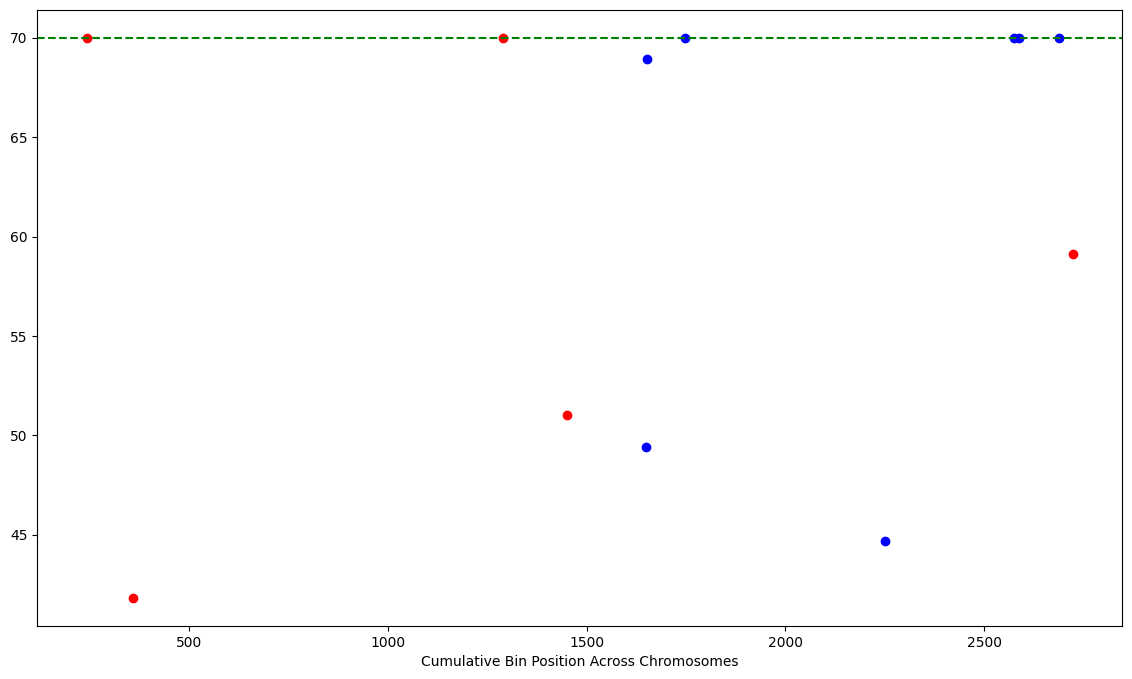

In [9]:
####################################################################################
# make dictionaries
####################################################################################
    
# Initialize dictionaries to store the averaged compartments for GM12878 and IMR90
gm12878_avg_dict = {}
imr90_avg_dict = {}

# Process each chromosome
for chr_num in range(1, 23):
    chr_name = f'chr{chr_num}'
    
    if chr_name in chromosome_results:
        sc_dataframe = chromosome_results[chr_name]
        
        # Filter the DataFrame by cell type
        gm12878_df = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']
        imr90_df = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']
        
        # Stack the A/B compartments for each cell type
        gm12878_compartments = np.stack(gm12878_df['A/B Compartment'].values)
        imr90_compartments = np.stack(imr90_df['A/B Compartment'].values)
        
        # Calculate the average for each bin across all vectors, taking NaNs into account
        gm12878_avg = np.nanmean(gm12878_compartments, axis=0)
        imr90_avg = np.nanmean(imr90_compartments, axis=0)
        
        # Store the results in the dictionaries
        gm12878_avg_dict[chr_name] = gm12878_avg
        imr90_avg_dict[chr_name] = imr90_avg

#####################################################################################
#set thresholds and calculate differnetially expressed bins
#####################################################################################

greater_than_threshold = 40.0  # Example: much greater than 1

# Define the cutoff for plotting outliers
max_ratio_cutoff = 70.0  # Cap very high ratios

# Initialize lists to store the results
high_gm12878_low_imr90_bins = []
high_imr90_low_gm12878_bins = []

# Process each chromosome
for chr_num in range(1, 23):
    chr_name = f'chr{chr_num}'
    
    if chr_name in gm12878_avg_dict and chr_name in imr90_avg_dict:
        gm12878_avg = gm12878_avg_dict[chr_name]
        imr90_avg = imr90_avg_dict[chr_name]
        
        # Calculate two ratios
        ratio1 = gm12878_avg / imr90_avg  # GM12878 on top
        ratio2 = imr90_avg / gm12878_avg  # IMR90 on top
        
        for bin_idx in range(len(ratio1)):
            r_value1 = ratio1[bin_idx]
            r_value2 = ratio2[bin_idx]
            
            if np.isnan(r_value1) or np.isnan(r_value2):
                continue  # Skip bins with NaN values
            
            if r_value1 > greater_than_threshold:
                # Cap the ratio at max_ratio_cutoff if it's above the threshold
                capped_value = min(r_value1, max_ratio_cutoff)
                high_gm12878_low_imr90_bins.append((chr_name, bin_idx, capped_value))
            elif r_value2 > greater_than_threshold:
                # Cap the ratio at max_ratio_cutoff if it's above the threshold
                capped_value = min(r_value2, max_ratio_cutoff)
                high_imr90_low_gm12878_bins.append((chr_name, bin_idx, capped_value))

# Convert results to DataFrames for easier analysis
gm12878_vs_imr90_df = pd.DataFrame(high_gm12878_low_imr90_bins, columns=['Chromosome', 'Bin', 'Ratio (GM12878/IMR90)'])
imr90_vs_gm12878_df = pd.DataFrame(high_imr90_low_gm12878_bins, columns=['Chromosome', 'Bin', 'Ratio (IMR90/GM12878)'])

###################################################################
# make image of differentially expressed bins
###################################################################
appropriate_sizes = {
    'chr1': 249,  
    'chr2': 243,
    'chr3': 198,
    'chr4': 191,  
    'chr5': 180,
    'chr6': 171,
    'chr7': 159,  
    'chr8': 146,
    'chr9': 141,
    'chr10': 135,   
    'chr11': 135,
    'chr12': 133,
    'chr13': 115,  
    'chr14': 107,
    'chr15': 102,
    'chr16': 90,  
    'chr17': 81,
    'chr18': 78,
    'chr19': 59,
    'chr20': 63,
    'chr21': 48,
    'chr22': 51
}

# Calculate cumulative positions
cumulative_sizes = {}
cumulative_position = 0

for chr_name, size in appropriate_sizes.items():
    cumulative_sizes[chr_name] = cumulative_position
    cumulative_position += size

# Function to get cumulative bin position
def get_cumulative_position(chromosome, bin_idx):
    return cumulative_sizes[chromosome] + bin_idx

# Apply cumulative positions to the dataframes
gm12878_vs_imr90_df['Cumulative Position'] = gm12878_vs_imr90_df.apply(
    lambda row: get_cumulative_position(row['Chromosome'], row['Bin']), axis=1)

imr90_vs_gm12878_df['Cumulative Position'] = imr90_vs_gm12878_df.apply(
    lambda row: get_cumulative_position(row['Chromosome'], row['Bin']), axis=1)

# Plotting the differentially expressed bins with outliers capped
plt.figure(figsize=(14, 8))
plt.scatter(gm12878_vs_imr90_df['Cumulative Position'], gm12878_vs_imr90_df['Ratio (GM12878/IMR90)'], c='blue', label='GM12878 >> IMR90')
plt.scatter(imr90_vs_gm12878_df['Cumulative Position'], imr90_vs_gm12878_df['Ratio (IMR90/GM12878)'], c='red', label='IMR90 >> GM12878')
plt.axhline(y=max_ratio_cutoff, color='g', linestyle='--', label=f'Max Cap ({max_ratio_cutoff})')
plt.xlabel('Cumulative Bin Position Across Chromosomes')
plt.ylabel(f'Ratio Capped at {min_ratio_cutoff} and {max_ratio_cutoff}')
plt.title('Significantly Differentially Expressed Bins Across Chromosomes (Outliers Capped)')
plt.legend()
plt.grid(True)

# Add vertical lines to separate chromosomes
for chr_name, size in appropriate_sizes.items():
    plt.axvline(x=cumulative_sizes[chr_name], color='black', linestyle='--', linewidth=0.5)

plt.show()




In [53]:
#################################################################
# Filter bulk vectors and single-cell data to get values on differential bins
#################################################################

# Combine the cumulative positions from the differential bins
all_cumulative_positions = np.concatenate([
    gm12878_vs_imr90_df['Cumulative Position'].values,
    imr90_vs_gm12878_df['Cumulative Position'].values
])

# Sort the cumulative positions if needed
cumulative_differential_positions = np.sort(all_cumulative_positions)

# Initialize dictionaries to store combined data for each sample
combined_ab_compartments = {}

# Calculate cumulative positions for bulk eigenvectors
cumulative_position = 0

for chr_num in range(1, 23):
    chr_name = f'chr{chr_num}'
    
    # Get the bulk eigenvectors for the current chromosome
    bulk_eigenvector_gm12878 = original_bulk_data[f'res1000000_ch{chr_num}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
    bulk_eigenvector_imr90 = original_bulk_data[f'res1000000_ch{chr_num}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values
    
    # Get the single-cell A/B Compartment data
    sc_df = chromosome_results[chr_name].copy()  # Copy to avoid SettingWithCopyWarning
    
    # Ensure that the lengths match
    min_length = min(len(bulk_eigenvector_gm12878), len(sc_df))
    bulk_eigenvector_gm12878 = bulk_eigenvector_gm12878[:min_length]
    bulk_eigenvector_imr90 = bulk_eigenvector_imr90[:min_length]
    sc_df['A/B Compartment'] = sc_df['A/B Compartment'].apply(lambda x: np.array(x)[:min_length])

    # Assign cumulative positions to each bin in the bulk data
    cumulative_positions = np.arange(cumulative_position, cumulative_position + min_length)
    
    # Update cumulative positions and append A/B Compartment data for each sample
    for idx, row in sc_df.iterrows():
        sample_id = row['Sample']
        ab_compartment = row['A/B Compartment']
        
        if sample_id not in combined_ab_compartments:
            combined_ab_compartments[sample_id] = ab_compartment
        else:
            combined_ab_compartments[sample_id] = np.concatenate([combined_ab_compartments[sample_id], ab_compartment])
    
    # Update cumulative position
    cumulative_position += appropriate_sizes[chr_name]

# Convert the combined data into a DataFrame
sc_df_combined_df = pd.DataFrame({
    'Sample': list(combined_ab_compartments.keys()),
    'A/B Compartment': list(combined_ab_compartments.values())
})

# Convert to numpy arrays
bulk_eigenvector_gm12878_combined = np.array(bulk_eigenvector_gm12878_combined)
bulk_eigenvector_imr90_combined = np.array(bulk_eigenvector_imr90_combined)
bulk_positions = np.array(bulk_positions)

# Filter bulk eigenvectors based on the differential positions
differential_indices = np.isin(bulk_positions, cumulative_differential_positions)

bulk_eigenvector_gm12878_differential_bins = bulk_eigenvector_gm12878_combined[differential_indices]
bulk_eigenvector_imr90_differential_bins = bulk_eigenvector_imr90_combined[differential_indices]

# Apply the filtering row by row for the single-cell data
sc_df_combined_df['A/B Compartment'] = sc_df_combined_df['A/B Compartment'].apply(
    lambda x: np.array(x)[differential_indices[:len(x)]]
)

# The resulting sc_df_combined_df now has filtered A/B Compartment values
sc_df_differential_bins = sc_df_combined_df.copy()


TypeError: list indices must be integers or slices, not tuple

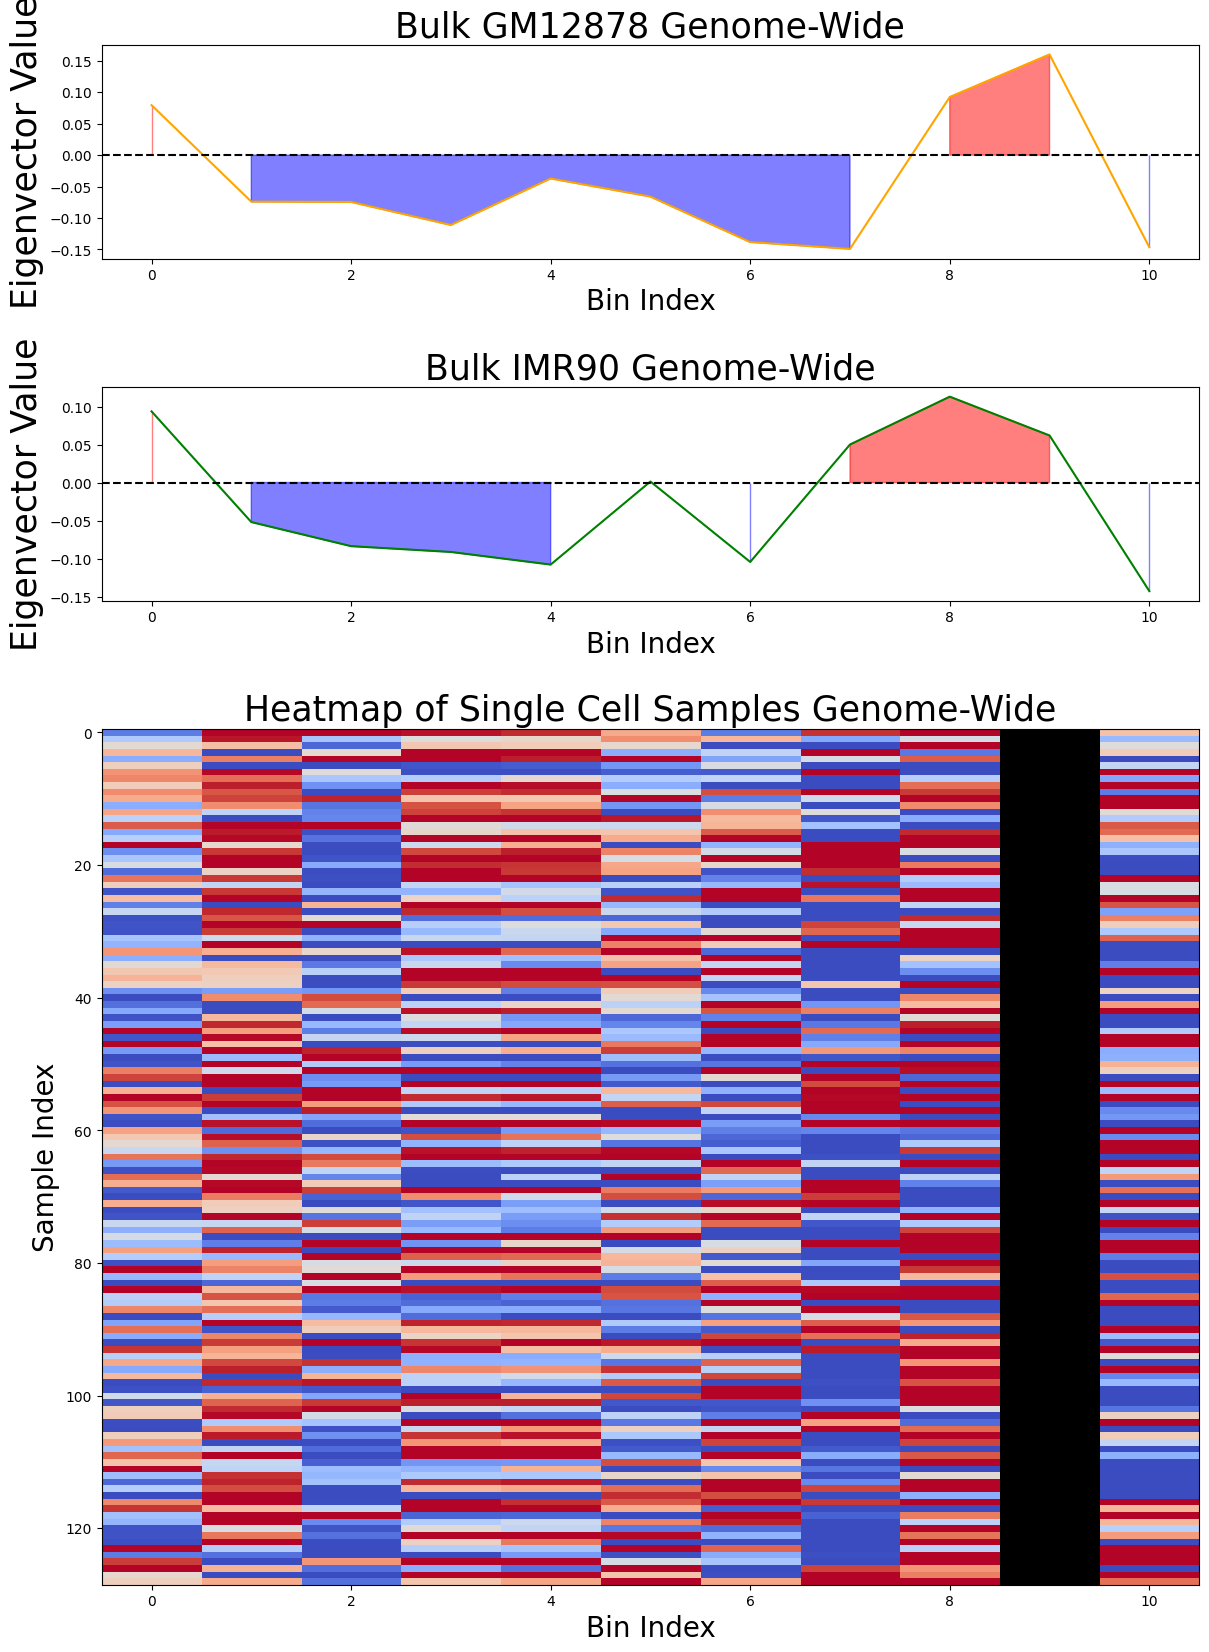

In [63]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import textwrap

# Plot the combined bulk eigenvectors and heatmap
def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_data_array, title1, title2, title, cumulative_sizes, appropriate_sizes, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 20))  # Adjust the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    # Plot for GM12878 bulk eigenvector
    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 >= 0), color='red', alpha=0.5)
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 < 0), color='blue', alpha=0.5)
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    # Plot for IMR90 bulk eigenvector
    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 >= 0), color='red', alpha=0.5)
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 < 0), color='blue', alpha=0.5)
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='darkgrey')  # Set NaN color to black

    # Plot for single-cell heatmap
    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples Genome-Wide", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(sc_data_array[:bulk_eigenvector1.shape[0], :])
    num_imr90 = len(sc_data_array[-bulk_eigenvector2.shape[0]:, :])
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('NTF Compartment Call', rotation=270, labelpad=25, fontsize=25)

    # Add vertical lines and labels to indicate chromosome boundaries
    for chr_name, cum_pos in cumulative_sizes.items():
        ax_sc.axvline(x=cum_pos, color='black', linestyle='--', linewidth=0.5)
        ax_bulk1.axvline(x=cum_pos, color='black', linestyle='--', linewidth=0.5)
        ax_bulk2.axvline(x=cum_pos, color='black', linestyle='--', linewidth=0.5)

        # Calculate midpoint for chromosome label
        chr_midpoint = cum_pos + appropriate_sizes[chr_name] / 2
        ax_sc.text(chr_midpoint, ax_sc.get_ylim()[0] - 5, chr_name, fontsize=15, ha='center', va='top', color='white')

    plt.suptitle(title, fontsize=45, fontweight='bold')  

    # Construct the caption
    caption = (f"Figure 1: The single cell A/B compartment calls from the NTF model visually separate the " 
               f"There is no normalization of the Hi-C data. Low rank approximations were computed with {iterations} iterations."
              )

    # Use textwrap to wrap the caption text within a specific width
    wrapped_caption = textwrap.fill(caption, width=100)

    # Add the caption at the bottom with automatic wrapping
    plt.figtext(0.01, -0.1, wrapped_caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878_differential_bins,
    bulk_eigenvector_imr90_differential_bins,
    sc_df_differential_bins['A/B Compartment'].tolist(),
    f"Bulk GM12878 Genome-Wide",
    f"Bulk IMR90 Genome-Wide",
    "NTF Single Cell Compartment Calls Across Genome",
    cumulative_sizes=cumulative_sizes,  # Pass the cumulative sizes
    appropriate_sizes=appropriate_sizes,  # Pass the appropriate sizes
    save_path=f"../../files/AB_compartment_heatmap_genome_wide_example_iter{iterations}.png"
)


In [70]:
bulk_eigenvector_gm12878_differential_bins

array([ 0.07948382, -0.07393196, -0.07443532, -0.11109291, -0.03713243,
       -0.06594795, -0.13821427, -0.14903637,  0.09241965,  0.1601031 ,
       -0.14641757])

In [71]:
sc_df_differential_bins['A/B Compartment'].tolist()[3]

array([ 0.0032943 , -0.01      ,  0.00060844,  0.01      ,  0.01      ,
       -0.00500755, -0.00202841,  0.01      , -0.00791381,         nan,
        0.00184859])